# Sampling from a multivariate Normal distribution

Lets import some libraries that we're going to use. 

We're going to need:

 - *numpy* because there's nothing we can do without it,
 - *sklearn* to produce a mock covariance matrix for the normal distribution,
 - *matplotlib* to plot the covariance matrix and visually inspect our results,
 - *getdist* to plot the marginalised posterior distributions,
 
and of course  **zeus** to perform MCMC Bayesian Inference.

In [1]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import zeus

Now we need to define:

 - *ndim* the number of dimensions/parameters of our distribution,
 - *nwalkers* the number of walkers, as a rule of thumb we choose the minimum value, twice the number of parameters,
 - *nsteps* the numper of steps/generations.
 
We also want to:

 - produce a mock covariance matrix using the *make_spd_matrix* function of *scikit-learn*,
 - compute its inverse,
 - define a random mean vector for our posterior distribution,
 - define the log probability of the posterior distribution as a python function,
 - provide a starting point for the sampler.

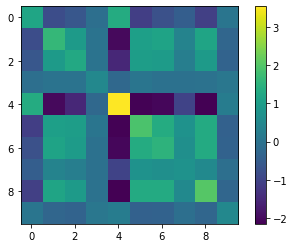

In [2]:
ndim = 10
nwalkers = 2*ndim
nsteps= 5000

C = make_spd_matrix(ndim)
plt.imshow(C)
plt.colorbar()
plt.show()

icov = np.linalg.inv(C)

mu = np.random.rand(ndim)

def logprob(x, mu, icov):
    return -0.5 * np.dot(np.dot((x-mu).T,icov),(x-mu))

start = np.random.randn(nwalkers, ndim)

Now we are ready to do some inference.

 - First we initialise the sampler by calling the *zeus.sampler* class,
 - and then we run the MCMC by calling the *run* method.
 
This is going to be very fast.

In [3]:
sampler = zeus.sampler(logprob, nwalkers, ndim, args=[mu, icov])
sampler.run(start, nsteps)

Initialising ensemble of 20 walkers...
Sampling progress : 100%|██████████| 5000/5000 [00:06<00:00, 794.29it/s]


Alright, lets plot our chains to see what we've got.
The chains are stored in the *sampler.chain* property, their shape is (nwalkers, nsteps, ndim). So we want to iterate over all dimensions and plot the results. We also plot the true values of the parameters so that we can compare the results.

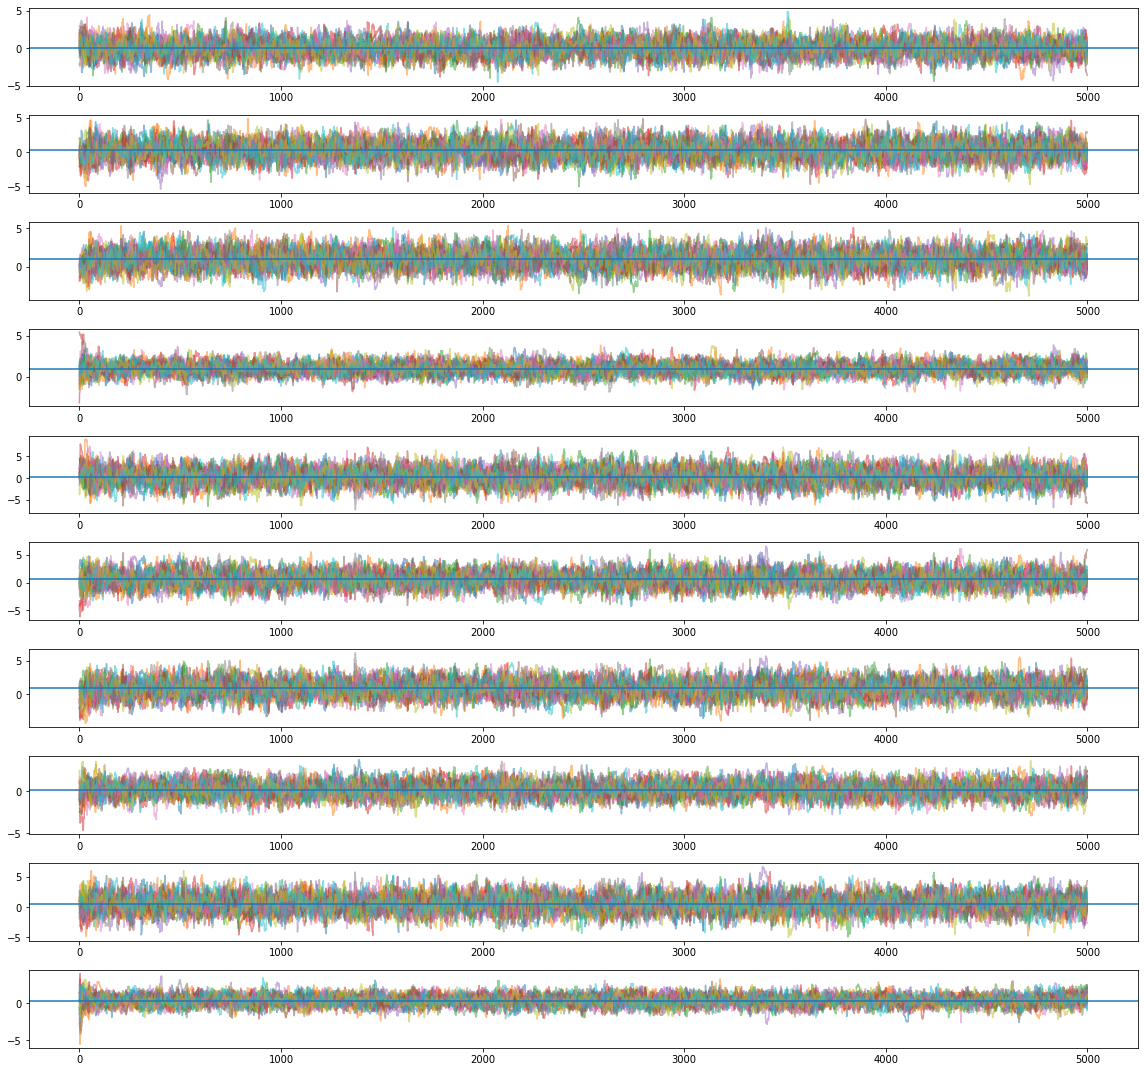

In [4]:
plt.figure(figsize=(16,1.5*ndim))
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(np.arange(nsteps),sampler.chain[:,:,n].T,alpha=0.5)
    plt.axhline(y=mu[n])
plt.tight_layout()
plt.show()

Great! This looks very good.

Now lets cut this burn-in phase off. We can either do this manually using *numpy* or even better use *zeus*'s flatten method. We are going to discard (or burn) the first half of the chain.

In [5]:
trace = sampler.flatten(burn=2500)

We can now compute some usefull statistics:

In [6]:
print('Percentiles')
print (np.percentile(trace, [16, 50, 84], axis=0))
print('Mean')
print (np.mean(trace, axis=0))
print('Standard Deviation')
print (np.std(trace, axis=0))

Percentiles
[[-1.07514182 -1.00667248 -0.17712471  0.30415    -1.5426101  -0.74603194
  -0.34562918 -0.67316016 -0.83652267 -0.35077991]
 [ 0.01378648  0.27152833  0.9676218   0.983946    0.33792812  0.59981224
   0.87745243  0.18557217  0.55157682  0.37196898]
 [ 1.08289848  1.5603967   2.11849231  1.69537195  2.24642875  1.96902629
   2.09289028  1.0575715   1.95919416  1.06579829]]
Mean
[0.0099296  0.27531041 0.96849967 0.99235714 0.34672692 0.61010357
 0.87566165 0.19064315 0.55731011 0.36250751]
Standard Deviation
[1.08027787 1.28116862 1.15124578 0.70463967 1.88250156 1.37246776
 1.23027002 0.86626702 1.40395042 0.71407385]


Last but not least, we can also plot the marginalised posterior distributions:

Removed no burn in


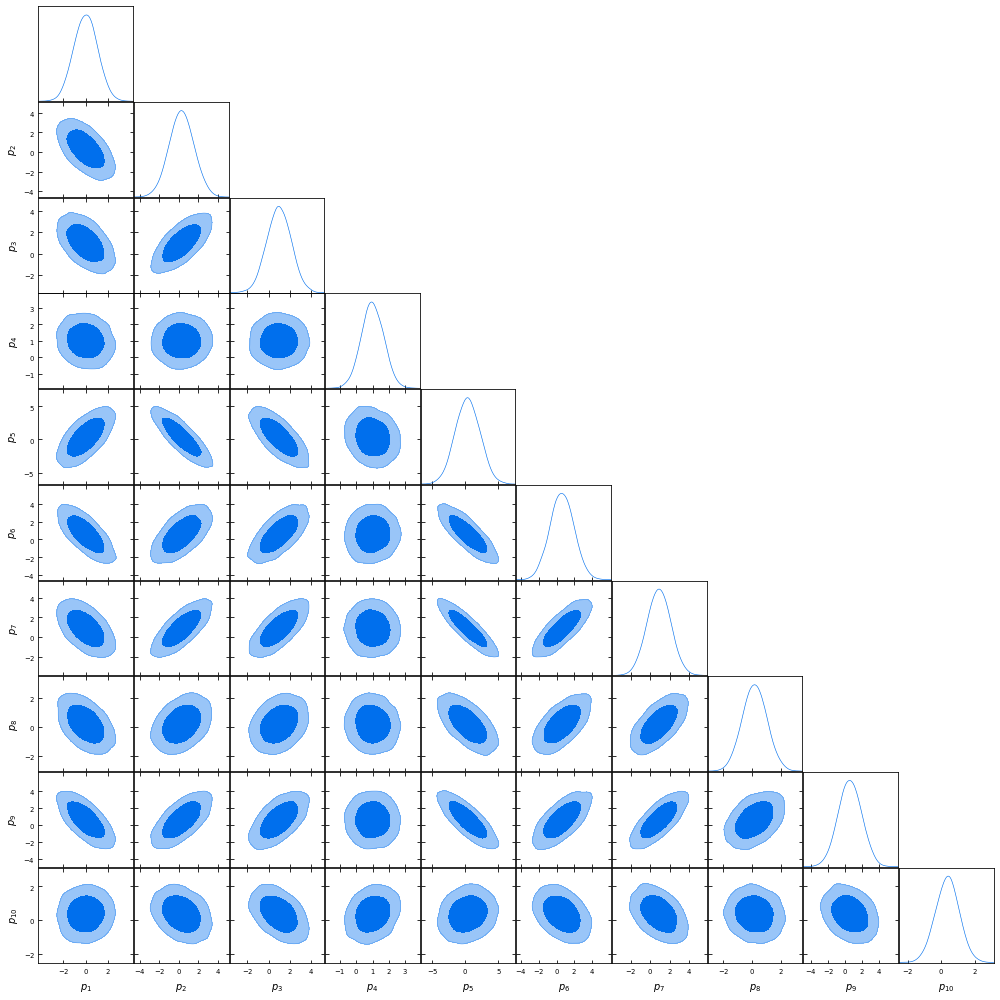

In [8]:
sample = MCSamples(samples=trace)
g = plots.getSubplotPlotter(width_inch=14)
g.triangle_plot([sample], filled=True, shaded=False) 